# Self-supervised and multi-modal representation Learning: Notebook 1

**Introductory tutorial for the IAIFI astro hackathon**

Siddharth Mishra-Sharma (smsharma@mit.edu)

In [1]:
from IPython.display import Image

We often deal with large amounts of unlabeled data in astro[nomy/physics], which we'd like to use to find interesting patterns etc. Astronomical observations are also often inherently _multi-modal_, providing multiple representations of the same underlying object/phenomenon (e.g., images and spectra). 

In this set of notebooks, we'll explore the use self-supervision techniques to learn meaningful representations of the data, which can then be adapted to different tasks using multi-modal and weak supervision.

We'll use data from the [Zwicky Transient Facility](https://www.ztf.caltech.edu/) (ZTF), which is a time-domain survey that scans the entire northern sky every two days. As such, ZTF provides a rich dataset, with billions of light curves.

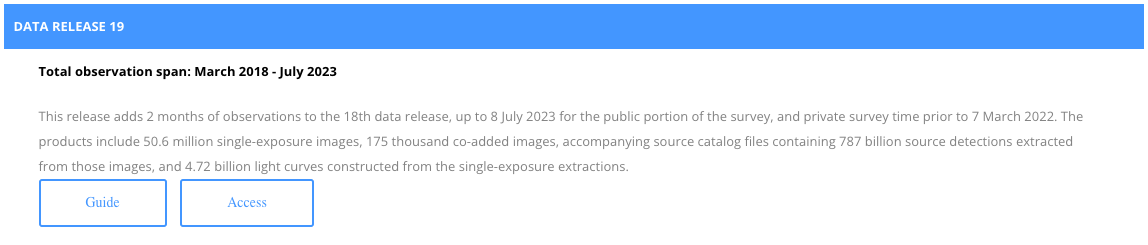

In [2]:
# From https://www.ztf.caltech.edu/ztf-public-releases.html; that's a lot of light curves!
Image(filename='assets/ztf_data.png', width=1024)

The ZTF Bright Transient Survey (https://www.ztf.caltech.edu/ztf-bts.html) is a spectroscopic supernova survey providing high-quality followup observations of supernovae seen by ZTF. About ~5000 light curves are available so far, with host galaxy associations, their images, as well as properties like spectroscopic redshifts.

Properties of the sample can be explored here: https://sites.astro.caltech.edu/ztf/bts/explorer.php. This will be the "high-quality labeled dataset" we'll use, also leveraging the associations between host galaxy images and light curves. 

## Exploratory data analysis

Let's start by just getting a feel for what the data looks like.

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

%load_ext autoreload
%autoreload 2

### Images (BTS sample)

If note running on Bridges-2, we've provided the current BTS sample in the [`data`](../data/) directory (`ZTFBTS.zip`). Go ahead an unzip it (`unzip ZTFBTS.zip`). 

Otherwise, the data is available at `/ocean/projects/phy230064p/shared/ZTFBTS/`

Let's look at some of the host galaxy images.

In [ ]:
# data_dir = "../data/ZTFBTS/"  # If unzipped locally
data_dir = "/ocean/projects/phy230064p/shared/ZTFBTS/" # If running on Bridges-2

In [4]:
dir_host_imgs = f"{data_dir}/hostImgs/"

host_imgs = []

for filename in os.listdir(dir_host_imgs):
    file_path = os.path.join(dir_host_imgs, filename)

    if file_path.endswith(".png"):
        host_img = Image.open(file_path).convert('RGB')
        host_img = np.asarray(host_img)
        host_imgs.append(host_img)

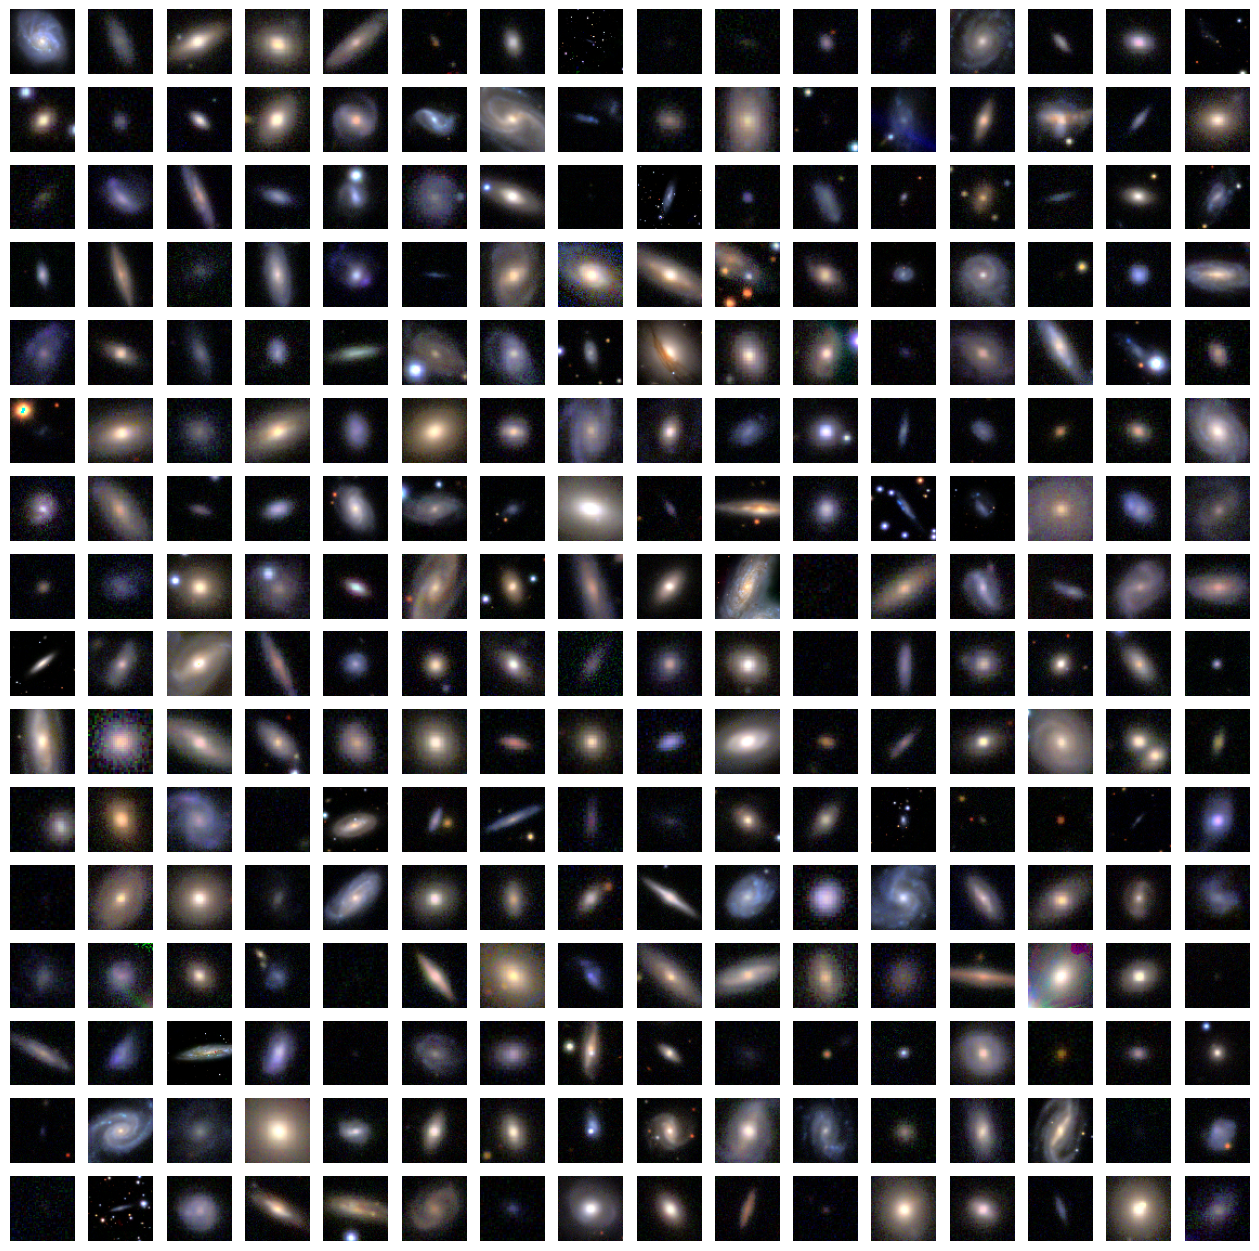

In [5]:
# Plot a grid of host galaxy images
fig, axs = plt.subplots(16, 16, figsize=(16, 16))
for i in range(16):
    for j in range(16):
        axs[i, j].imshow(host_imgs[i * 16 + j])
        axs[i, j].axis('off')

### Light curves (BTS sample)

Now let's at light curves.

In [6]:
dir_light_curves = f"{data_dir}/light-curves/"

def open_light_curve_csv(filename):
    """ Helper function to open a light curve csv file.
    """
    file_path = os.path.join(dir_light_curves, filename)
    df = pd.read_csv(file_path)
    return df

light_curve_df = open_light_curve_csv("ZTF18aailmnv.csv")
light_curve_df.head()

,time,mag,magerr,band
0,58312.219097,20.132299,0.252360,R
1,58319.205984,18.713728,0.104188,g
2,58319.224942,18.808235,0.092660,R
3,58320.174525,18.467438,0.093920,g
4,58324.179444,18.514769,0.117073,R


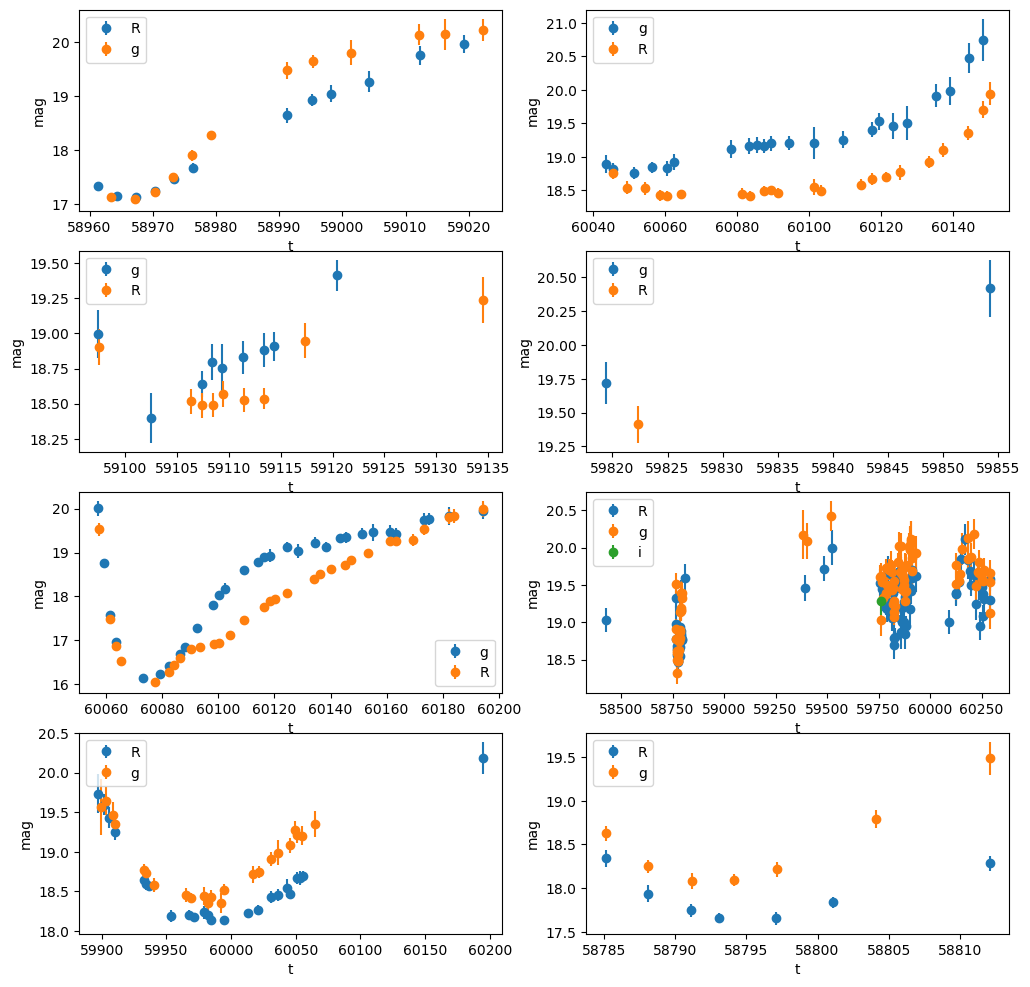

In [7]:
lightcurve_files = os.listdir(dir_light_curves)

# Plot a grid of light curves
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
for i in range(4):
    for j in range(2):
        light_curve_df = open_light_curve_csv(lightcurve_files[i * 2 + j])
        bands = light_curve_df['band'].unique()
        for band in bands:
            df_band = light_curve_df[light_curve_df['band'] == band]
            axs[i, j].errorbar(df_band['time'], df_band['mag'], yerr=df_band['magerr'], fmt='o', label=band)
        axs[i, j].set_xlabel("t")
        axs[i, j].set_ylabel("mag")
        axs[i, j].legend()

### Sample properties

With this smaller sample we also have access to some properties like the spectroscopic redshifts.

In [8]:
df_properties = pd.read_csv("../data/ZTFBTS/ZTFBTS_TransientTable.csv")
df_properties.head()

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,hostabs,hostcol,b,A_V
0,ZTF17aaazdba,AT2019azh,08:13:16.95,+22:38:53.9,561.73,g,15.2769,-19.76,66.42,24.318,42.102,TDE,0.022,-20.72,0.64,27.562336,0.122
1,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,-22.70,1.06,59.641962,0.053
2,ZTF17aacldgo,SN2022zxv,03:09:24.35,-04:53:39.2,1897.75,g,18.7979,-18.91,>8.87,>3.85,>5.02,SN Ia,0.072,-20.57,0.99,-50.332472,0.183
3,ZTF17aadlxmv,SN2020adv,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.062,-22.16,0.91,34.174702,0.106
4,ZTF18aaaibml,SN2020buc,10:08:31.27,+09:14:23.0,909.80,r,18.2606,-17.70,69.73,27.302,42.428,SN II,0.0348,-19.67,0.38,47.637802,0.092


Text(0, 0.5, 'count')

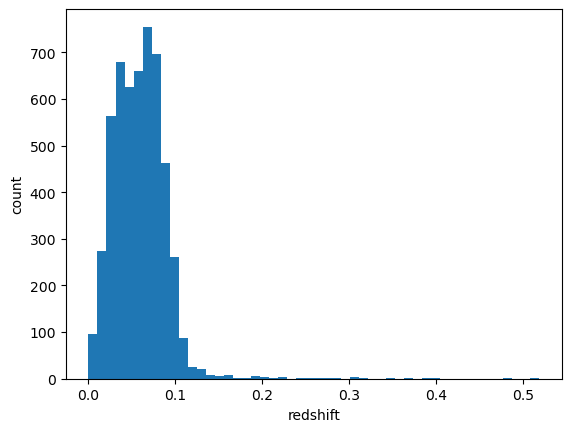

In [9]:
# Convert to float, if not possible then set to NaN
df_properties['redshift'] = pd.to_numeric(df_properties['redshift'], errors='coerce')

# Plot histogram of redshifts
plt.hist(df_properties['redshift'], bins=50);
plt.xlabel("redshift")
plt.ylabel("count")

### Light curves (bulk)

Now let's look at a few light curves from the bulk ZTF sample. These can be downloaded in bulk from [here](https://irsa.ipac.caltech.edu/Missions/ztf.html) (under "Lightcurve Bulk Download"). We've downloaded one `.parquet` file for now.

Data release notes: https://irsa.ipac.caltech.edu/data/ZTF/docs/releases/ztf_release_notes_latest.

In [17]:
import urllib.request
import os

# Base URL for the files
base_url = "https://irsa.ipac.caltech.edu/data/ZTF/lc/lc_dr20/1/field001605/"

# List of file names to download
file_names = [
    "ztf_001605_zg_c01_q1_dr20.parquet",
    "ztf_001605_zg_c01_q2_dr20.parquet",
    "ztf_001605_zg_c01_q3_dr20.parquet",
    "ztf_001605_zg_c01_q4_dr20.parquet",
    "ztf_001605_zg_c02_q1_dr20.parquet",
    "ztf_001605_zg_c02_q2_dr20.parquet",
    "ztf_001605_zg_c02_q3_dr20.parquet",
    "ztf_001605_zg_c02_q4_dr20.parquet",
    "ztf_001605_zg_c03_q1_dr20.parquet",
    "ztf_001605_zg_c03_q2_dr20.parquet",
    "ztf_001605_zg_c03_q3_dr20.parquet",
    "ztf_001605_zg_c03_q4_dr20.parquet",
    "ztf_001605_zg_c04_q1_dr20.parquet",
    "ztf_001605_zg_c04_q2_dr20.parquet",
    "ztf_001605_zg_c04_q3_dr20.parquet",
    "ztf_001605_zg_c04_q4_dr20.parquet",
    "ztf_001605_zg_c05_q1_dr20.parquet",
    "ztf_001605_zg_c05_q2_dr20.parquet",
    "ztf_001605_zg_c05_q3_dr20.parquet",
    "ztf_001605_zg_c05_q4_dr20.parquet",
    "ztf_001605_zg_c06_q1_dr20.parquet",
    "ztf_001605_zg_c06_q2_dr20.parquet"
]

# Specify the directory where you want to save the files
save_dir = "../data/lightcurves_bulk/"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Function to download a file
def download_file(url, save_path):
    try:
        urllib.request.urlretrieve(url, save_path)
        print(f"Downloaded {save_path}")
    except Exception as e:
        print(f"Error downloading {save_path}: {e}")

# Iterate through the file names and download each file
for file_name in file_names:
    file_url = base_url + file_name
    save_path = os.path.join(save_dir, file_name)
    download_file(file_url, save_path)

Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c01_q1_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c01_q2_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c01_q3_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c01_q4_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c02_q1_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c02_q2_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c02_q3_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c02_q4_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c03_q1_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c03_q2_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c03_q3_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c03_q4_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c04_q1_dr20.parquet
Downloaded ../data/lightcurves_bulk/ztf_001605_zg_c04_q2_dr20.parquet
Downloaded ../data/l

In [11]:
# ! pip install pyarrow

In [12]:
import pyarrow.parquet as pq

In [21]:
# Load a bulk light curve sample
bulk_df = pq.read_table(f"{save_dir}/{file_names[-1]}").to_pandas()
bulk_df.head()

,objectid,filterid,fieldid,rcid,objra,objdec,nepochs,hmjd,mag,magerr,clrcoeff,catflags
0,1605106200000000,1,1605,21,67.787560,22.404116,57,"[58362.51681, 58373.52475, 58380.52711, 58385....","[19.231728, 19.300705, 19.3377, 19.403196, 19....","[0.08695058, 0.09102992, 0.09327612, 0.0973468...","[-0.031921588, -0.062426936, -0.059965625, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 32768, 0, 0, 0,..."
1,1605106200000001,1,1605,21,68.170403,22.403904,50,"[58362.51677, 58373.52472, 58380.52708, 58385....","[19.651655, 19.929546, 20.035643, 19.891346, 1...","[0.11367621, 0.13246328, 0.13921976, 0.1299354...","[-0.031921588, -0.062426936, -0.059965625, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 32768, 0, 32768, 0, 0..."
2,1605106200000002,1,1605,21,68.575165,22.402355,65,"[58362.51673, 58373.52468, 58380.52704, 58385....","[18.598953, 18.564962, 18.601206, 18.638447, 1...","[0.05669087, 0.05542612, 0.056775935, 0.058204...","[-0.031921588, -0.062426936, -0.059965625, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 32768, 0, 0, 32768..."
3,1605106200000003,1,1605,21,68.621246,22.402176,64,"[58362.51673, 58373.52467, 58380.52704, 58385....","[18.259672, 18.273726, 18.25142, 18.230791, 18...","[0.045536183, 0.045936637, 0.04530334, 0.04472...","[-0.031921588, -0.062426936, -0.059965625, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 32768, 0, 0,..."
4,1605106200000004,1,1605,21,67.840157,22.403341,66,"[58362.5168, 58373.52475, 58380.52711, 58385.4...","[17.848478, 17.938187, 17.907227, 17.908741, 1...","[0.035846308, 0.037650067, 0.03700955, 0.03704...","[-0.031921588, -0.062426936, -0.059965625, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 32768, 0, 0, 32768..."


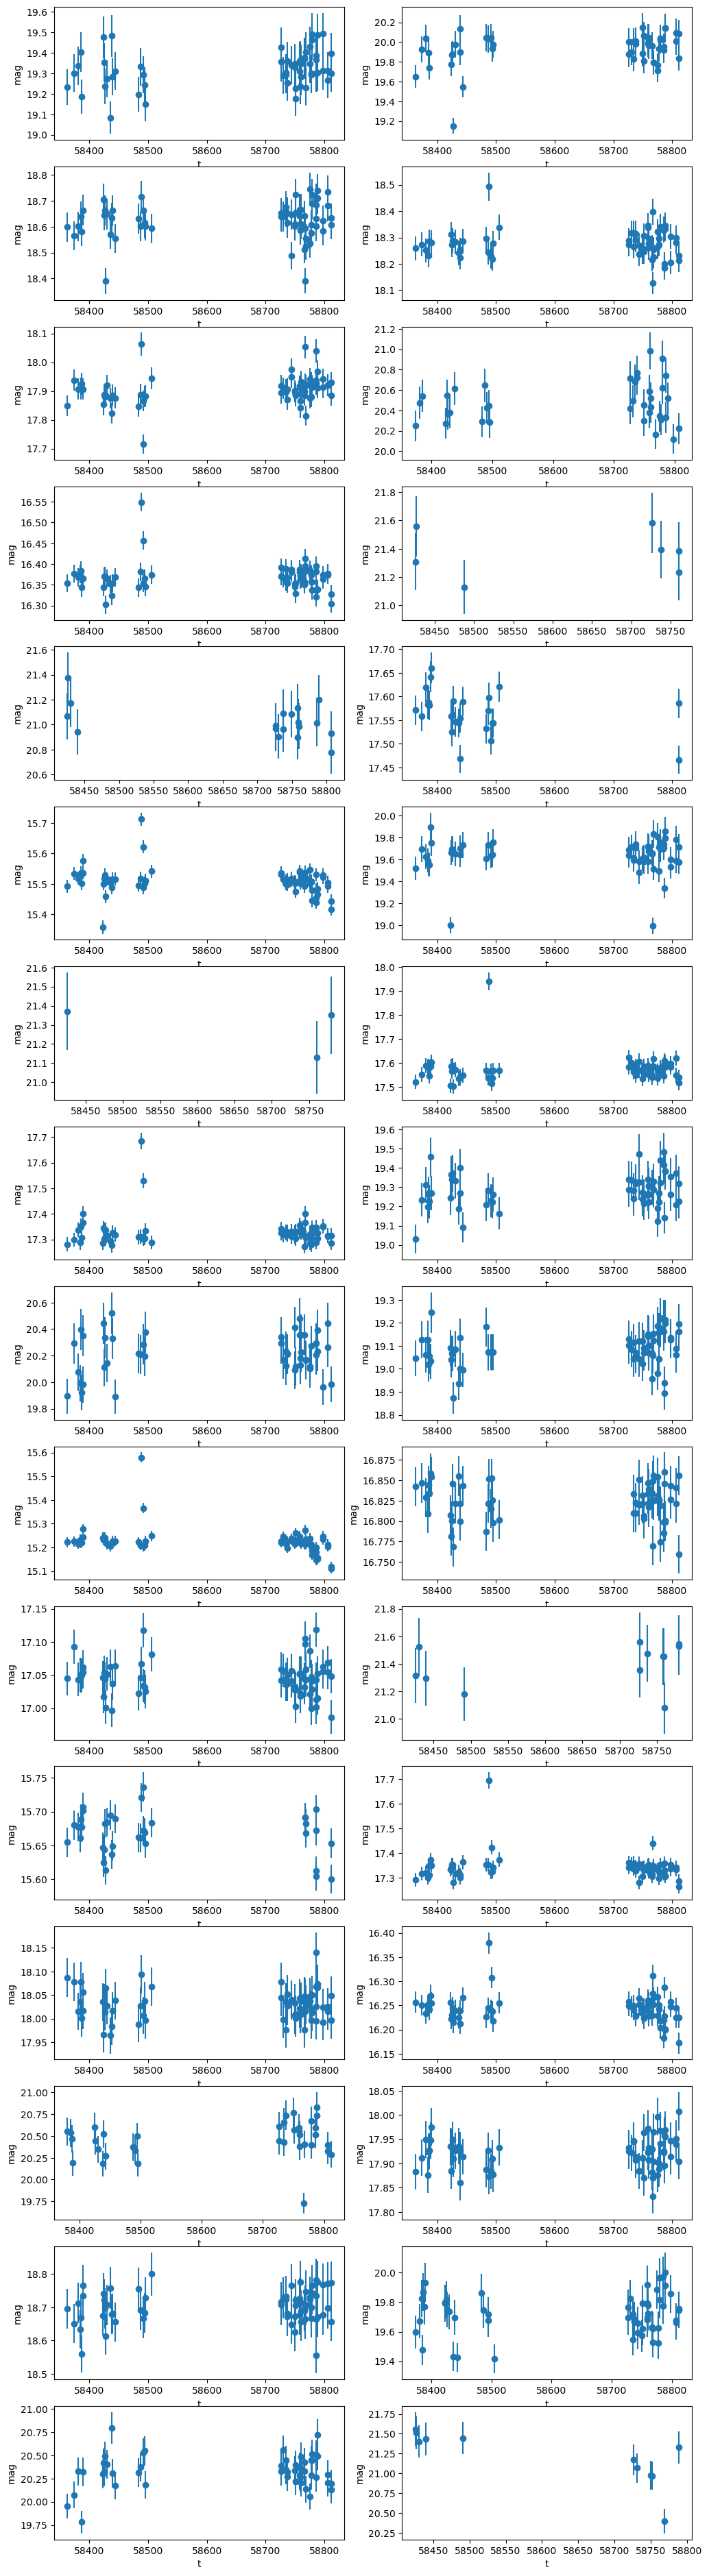

In [22]:
# Plot a grid of bulk light curves

n_row = 16
n_col = 2

fig, axs = plt.subplots(n_row, n_col, figsize=(12, 48))
for i in range(n_row):
    for j in range(n_col):
        row = bulk_df.iloc[i * n_col + j]
        axs[i, j].errorbar(row['hmjd'], row['mag'], yerr=row['magerr'], fmt='o')
        axs[i, j].set_xlabel("t")
        axs[i, j].set_ylabel("mag")

These clearly look different from the BTS sample already! This is a very noisy sample -- are there any quality cuts that might be useful? For example, a cut based on a correlation function of the points as a function of time-spacing?

This can help purify the sample and make it more amenable to learning good representations from, especially since we have access to tons of light curves.